_In this project we are exploring how comebacks, concepts and events influence ENHYPEN album sales and fan behaviour (sentiment, streamings). The project will be divided in 3 parts : album sales analysis, sentiment analysis across different kpop subreddits and, finally, Spotify popularity analysis._

## Importing libraries

In [70]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import seaborn as sns
import re, unicodedata
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Analysing album sales patterns

### Importing Data

<div class="alert alert-block alert-info">
<b>Album sales data source :</b> https://circlechart.kr/

_This data was collected manually. If you are interested in getting weekly data, you can also find it in the data folder._
_The free version of Circle Chart allowes you to only get the rankings, not the actual sales numbers. So we wil have to stick with that._
</div>

In [71]:
monthly_album_sales_ranking = pd.read_csv('data/enhypen_album_ranking_byMonth.csv', sep=";", encoding='cp1252')

<div class="alert alert-block alert-info">
<b>Events data source  :</b> https://www.enhypenguide.com/achievements

_This data was collected manually, you can add or delete other events if you want to. For instance, I only kept the events that I found to be relevant for this analysis._
</div>

In [72]:
notable_events = pd.read_csv('data/enhypen_events.csv', sep=";", encoding='cp1252')

### Cleaning data

In [73]:
# Define a function to clean the album names
def sanitize_filename(name):
    return re.sub(r'[\\/*?"<>|]', "", name)

In [74]:
# Apply the function to the 'album' column to create a new safe column
monthly_album_sales_ranking['album'] = monthly_album_sales_ranking['album'].apply(sanitize_filename)
monthly_album_sales_ranking['date'] = pd.to_datetime(monthly_album_sales_ranking[['year', 'month']].assign(DAY=1))

# We are not going to take the Weverse versions, since there is almost no data on those
monthly_album_sales_ranking = monthly_album_sales_ranking[monthly_album_sales_ranking["album"].str.contains("Weverse") == False]

In [75]:
monthly_album_sales_ranking.head()

,rank,year,month,album,date
0,42,2025,3,ROMANCE : UNTOLD,2025-03-01
1,99,2025,3,DIMENSION : DILEMMA,2025-03-01
2,55,2025,2,ROMANCE : UNTOLD,2025-02-01
3,79,2025,2,ROMANCE : UNTOLD -daydream-,2025-02-01
4,80,2025,2,DARK BLOOD,2025-02-01


In [76]:
monthly_album_sales_ranking.dtypes

rank              int64
year              int64
month             int64
album            object
date     datetime64[ns]
dtype: object

In [77]:
notable_events['date']=pd.to_datetime(notable_events['date'], dayfirst=True)
notable_events = notable_events.drop([3, 6, 7, 8, 16, 23])

In [78]:
notable_events.head()

,event,date
0,BORDER : DAY ONE,2020-11-30
1,BORDER : CARNIVAL,2021-04-26
2,DIMENSION : DILEMMA,2021-10-12
4,DIMENSION : ANSWER,2022-01-10
5,"ENHYPEN's First Webtoon Series, DARK MOON : Th...",2022-01-16


In [79]:
notable_events.dtypes

event            object
date     datetime64[ns]
dtype: object

### Plotting album sales ranking over the time

_We are plotting the album sales rankings and overlaying events to see the patterns (ex : sales increasing after an offline event)._ 

For the distribution, I chose Kernel Density Estimation plot to have a better visualisation.

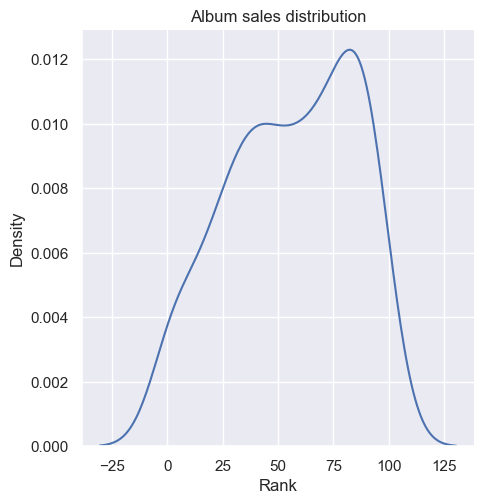

In [80]:
sns.set(color_codes=True)
sns.displot(monthly_album_sales_ranking, x=monthly_album_sales_ranking['rank'], kind="kde")
plt.title("Album sales distribution")
plt.xlabel("Rank")
plt.savefig("KDE_distribution.png", dpi=300, bbox_inches='tight')

Most albums rank around 80, but there are some albums in the 50 range. Let's see now the distribution goes for each album 

C:\Users\Pauline Leumani\AppData\Local\Temp\ipykernel_3616\1508851790.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(monthly_album_sales_ranking, x=monthly_album_sales_ranking['rank'], hue=monthly_album_sales_ranking['album'], kind="kde")


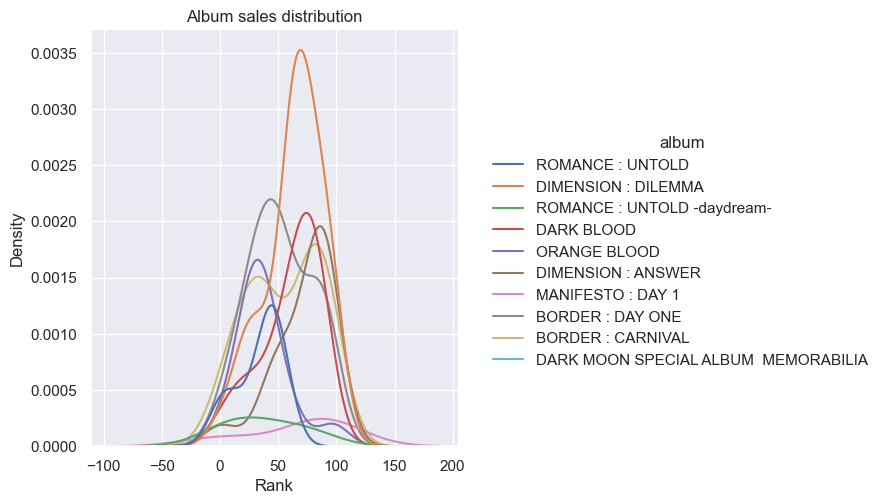

In [81]:
sns.set(color_codes=True)
sns.displot(monthly_album_sales_ranking, x=monthly_album_sales_ranking['rank'], hue=monthly_album_sales_ranking['album'], kind="kde")
plt.title("Album sales distribution")
plt.xlabel("Rank")
plt.savefig("KDE_distribution_per_album.png", dpi=300, bbox_inches='tight')

The highest rankings belong to BORDER : DAY ONE, ORANGE BLOOD and DIMENSION : DILEMMA. DARK BLOOD comes right after, followed by DIMENSION : ANSWER. 
MANIFESTO : DAY 1 didn't do as well. Same for ROMANCE : UNTOLD -daydream-. Surpisingly, ROMANCE : UNTOLD did much better.

Let's perform linear regression to see better what's going on. 

In [82]:
monthly_album_sales_ranking['date_ordinal']=monthly_album_sales_ranking['date'].map(dt.datetime.toordinal)

In [83]:
model = LinearRegression()

In [84]:
model.fit(monthly_album_sales_ranking[['date_ordinal']], monthly_album_sales_ranking[['rank']])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [85]:
r_sq = model.score(monthly_album_sales_ranking[['date_ordinal']], monthly_album_sales_ranking[['rank']])
print(f"Coefficient of determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

Coefficient of determination: 0.09071647084510792
Intercept: [-14107.01346884]
Slope: [[0.0191739]]


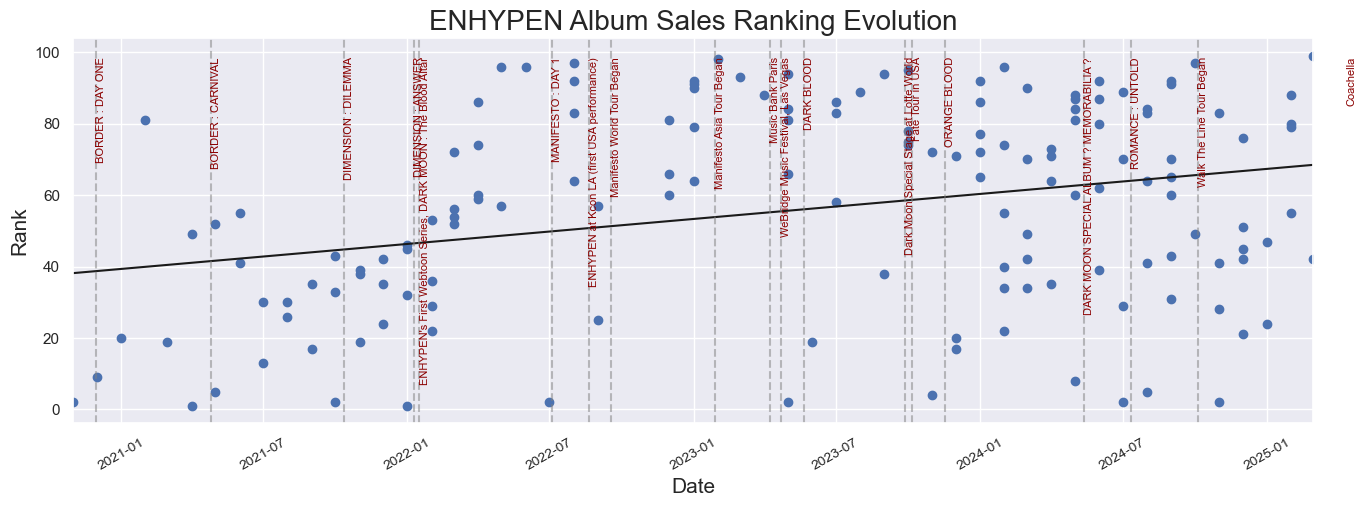

In [86]:
fig = plt.subplots(figsize=(16, 5))
y_pred = model.predict(monthly_album_sales_ranking[['date_ordinal']])
plt.scatter(monthly_album_sales_ranking['date'], monthly_album_sales_ranking['rank'], color='b')
plt.plot(monthly_album_sales_ranking[['date']], y_pred, color ='k')
plt.title('ENHYPEN Album Sales Ranking Evolution', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Rank', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.xlim(monthly_album_sales_ranking.date.min(), monthly_album_sales_ranking.date.max())
for _, row in notable_events.iterrows():
    plt.axvline(row['date'], color='gray', linestyle='--', alpha=0.5)
    plt.text(row['date'], plt.ylim()[1]*0.95, row['event'],
             rotation=90, verticalalignment='top', fontsize=8, color='darkred')
plt.savefig("Album_sales_linear_regression.png", dpi=300, bbox_inches='tight')
plt.show()

No clear linear growth or decline, the slope is positive, meaning that rankings tend to worsen over time (which is natural, the newer albums get higher sales) but it's very weak. Only 9% of the variance is explained by time, the rest depends on other factors such as events, fan behaviour etc.

Album sales per album

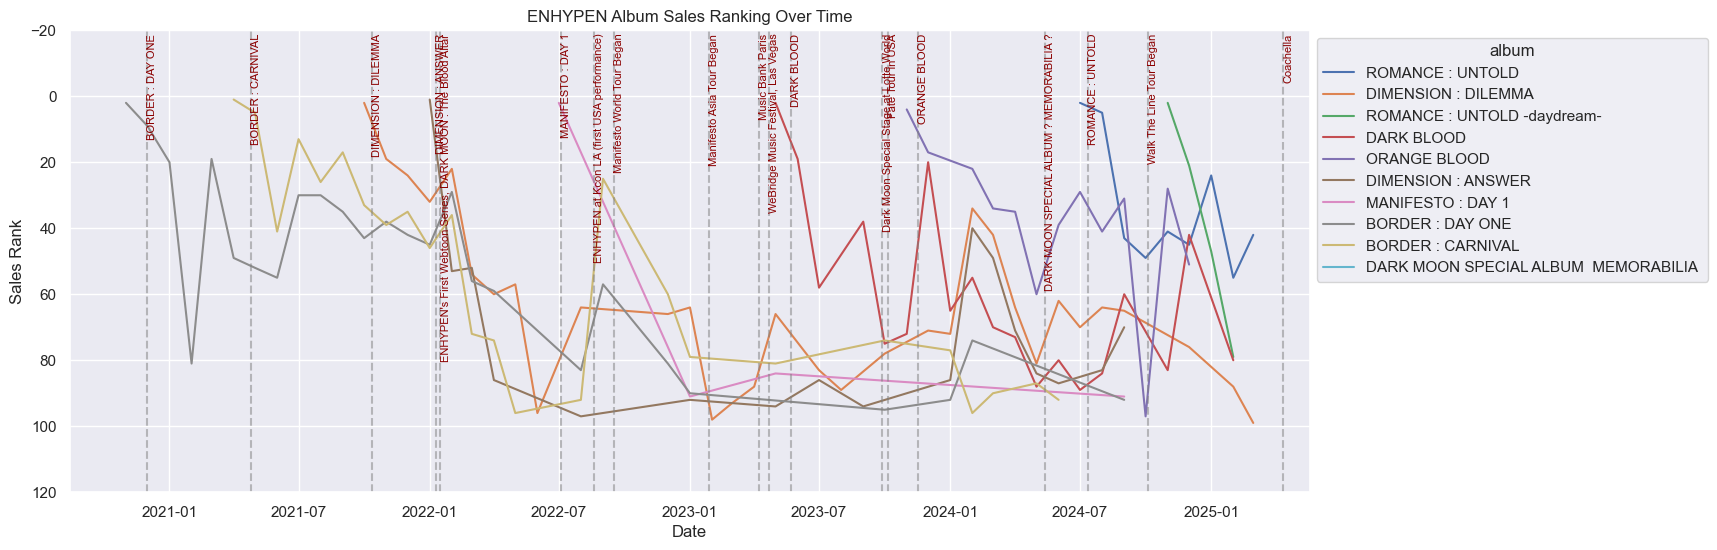

In [87]:
plt.figure(figsize=(16, 6))
ax=sns.lineplot(data=monthly_album_sales_ranking, x="date", y="rank", hue="album", palette="deep")
ax.set(ylim=(-20, 120))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()  # Better ranks = lower numbers
plt.xlabel('Date')
plt.ylabel('Sales Rank')
plt.title('ENHYPEN Album Sales Ranking Over Time')
plt.grid(True)

for _, row in notable_events.iterrows():
    plt.axvline(row['date'], color='gray', linestyle='--', alpha=0.5)
    plt.text(row['date'], plt.ylim()[1]*0.95, row['event'],
             rotation=90, verticalalignment='top', fontsize=8, color='darkred')
plt.savefig("enhypen_trend_plot.png", dpi=300, bbox_inches='tight')
plt.show()

Sales for each album

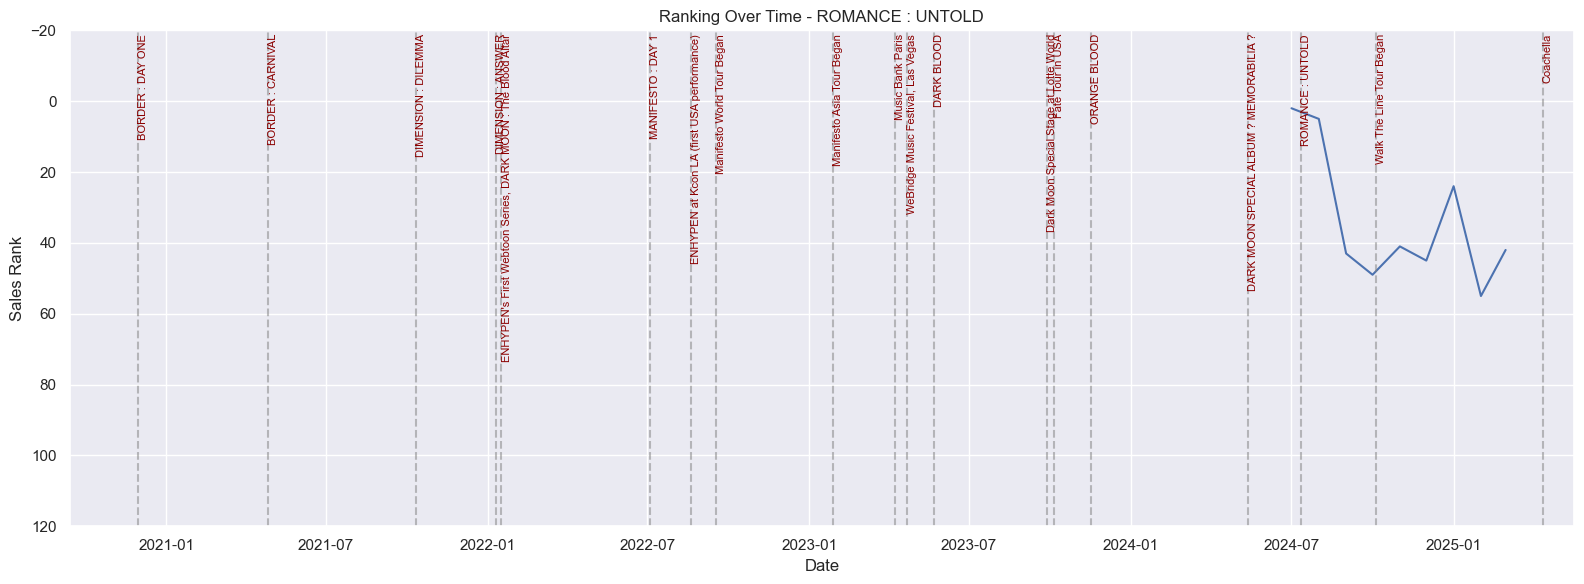

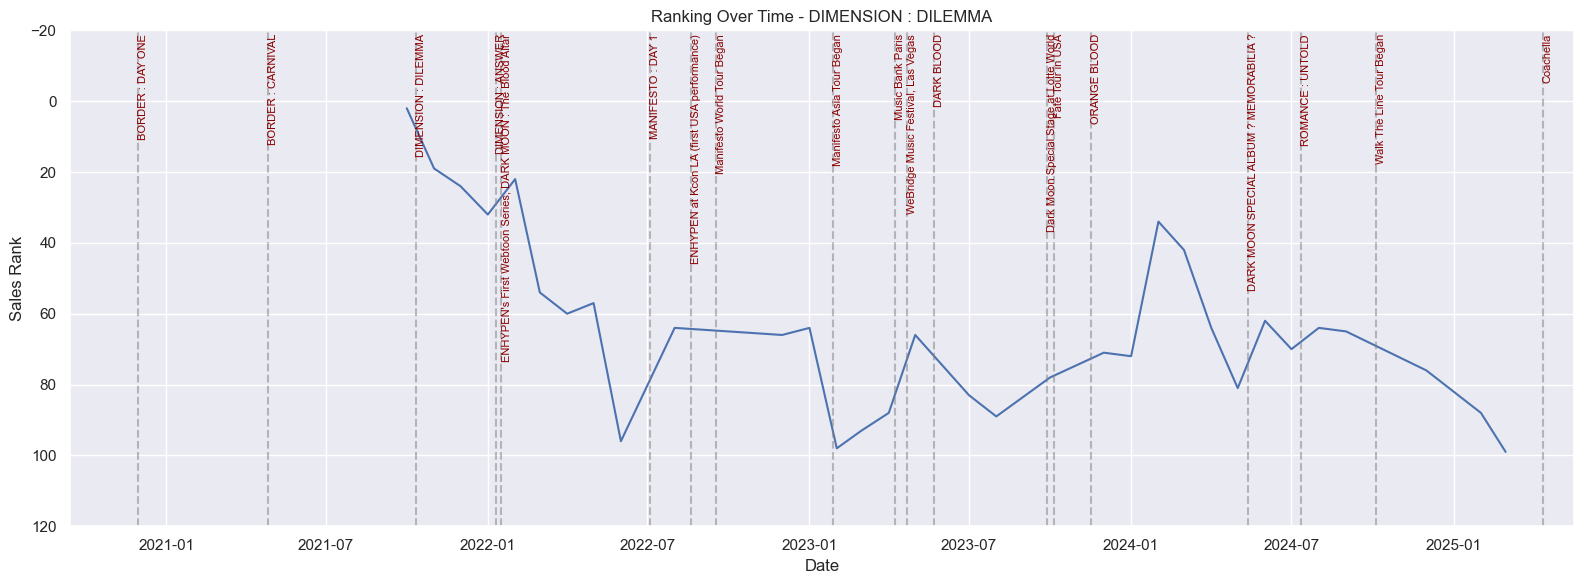

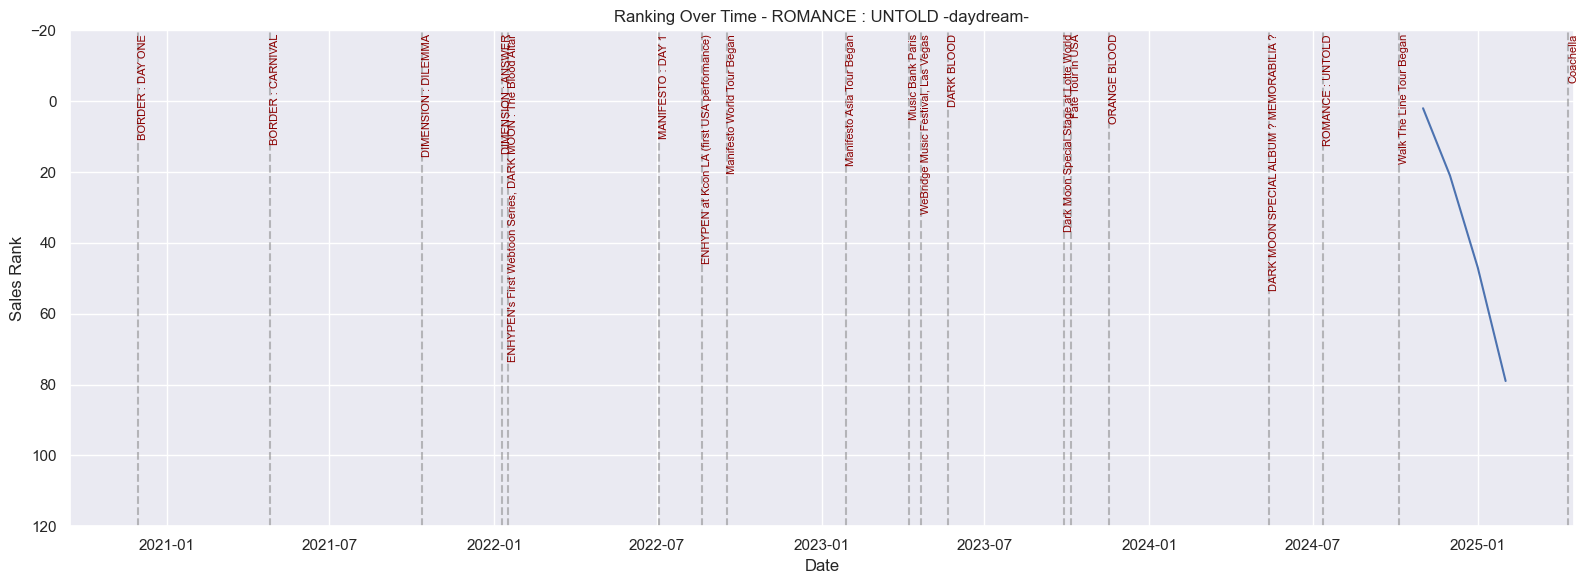

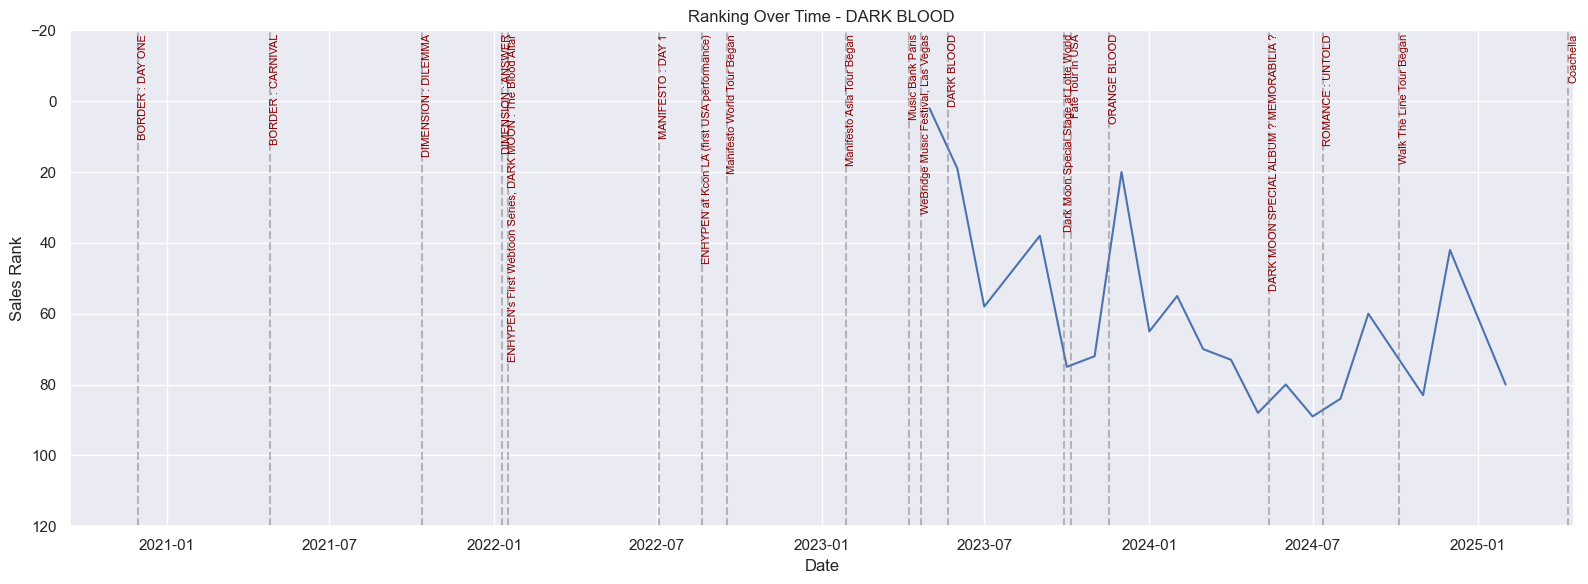

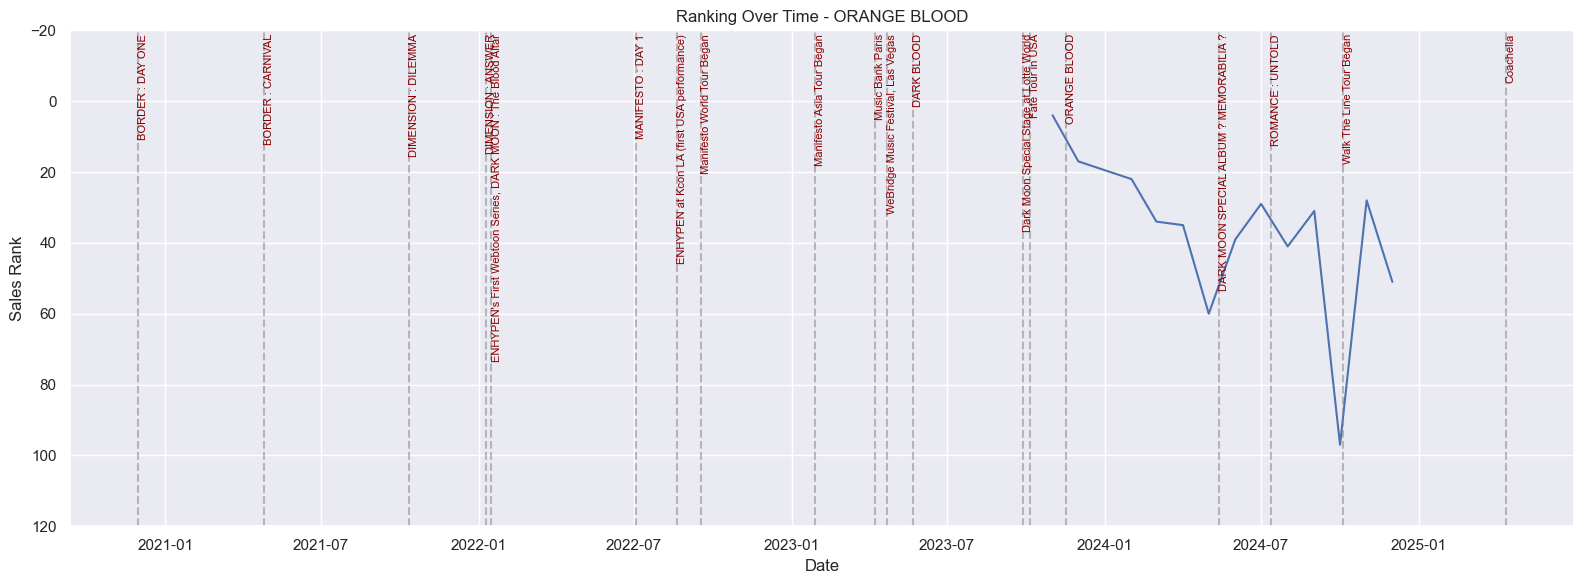

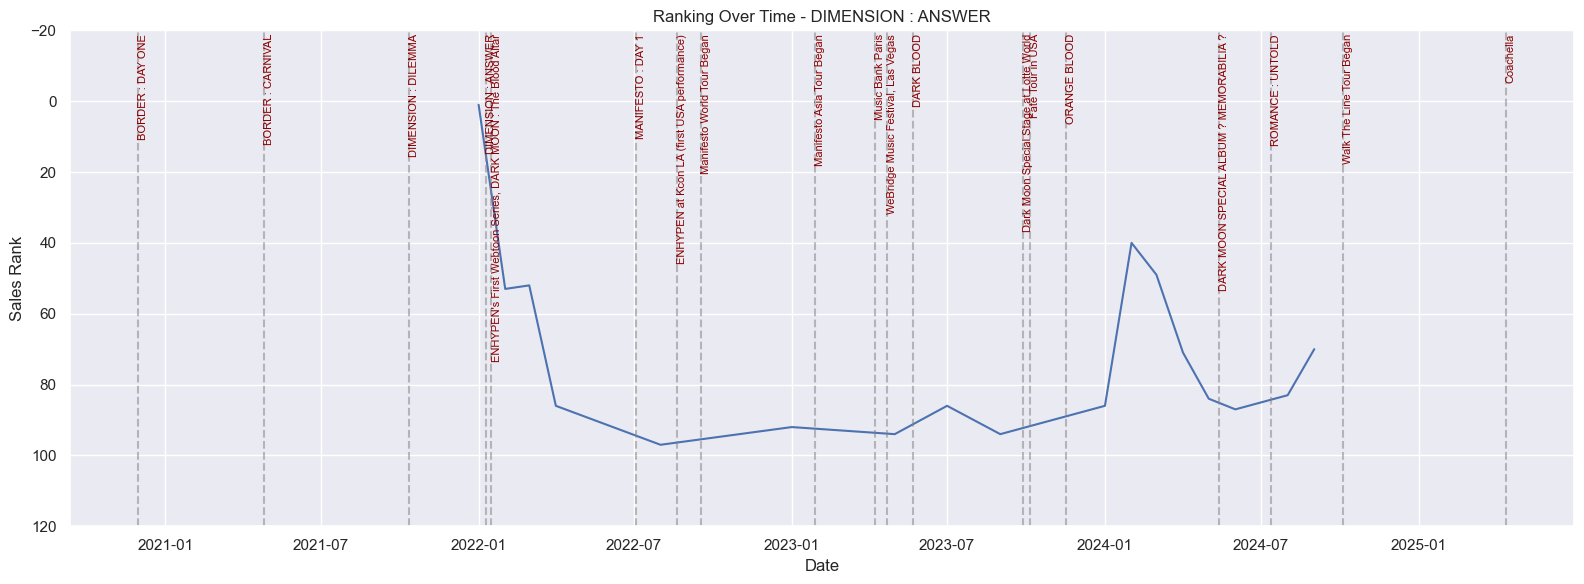

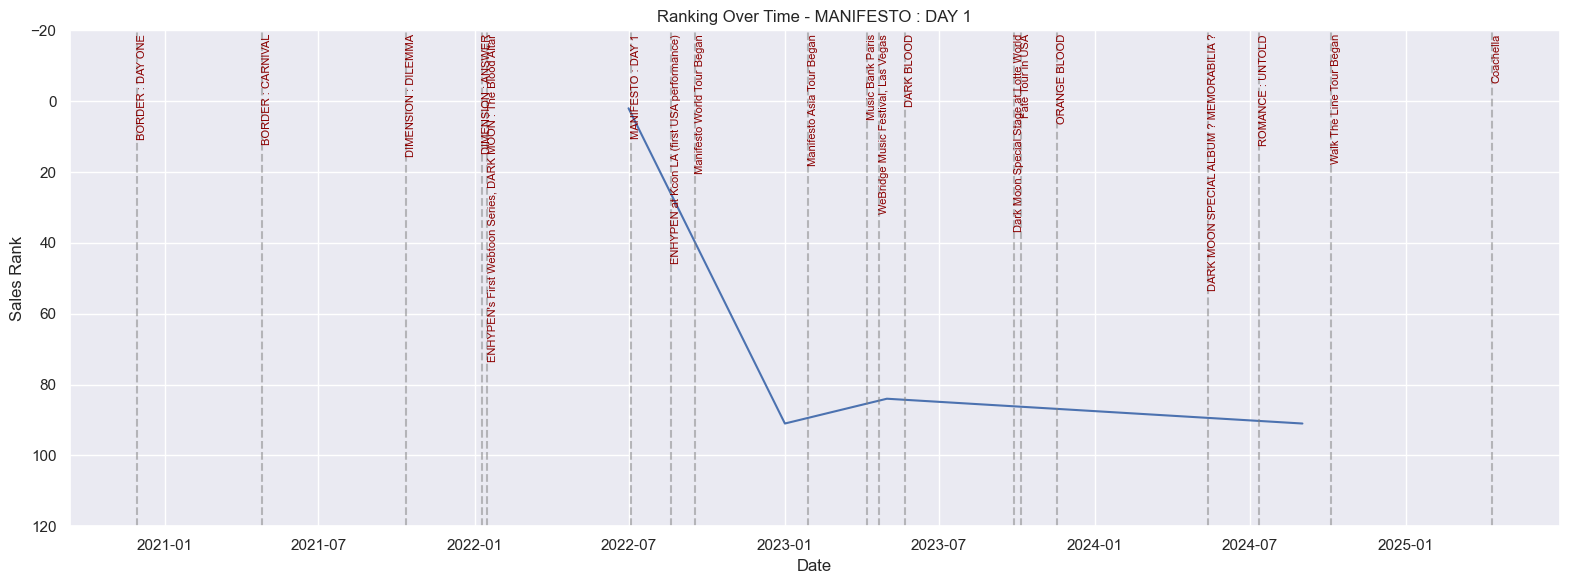

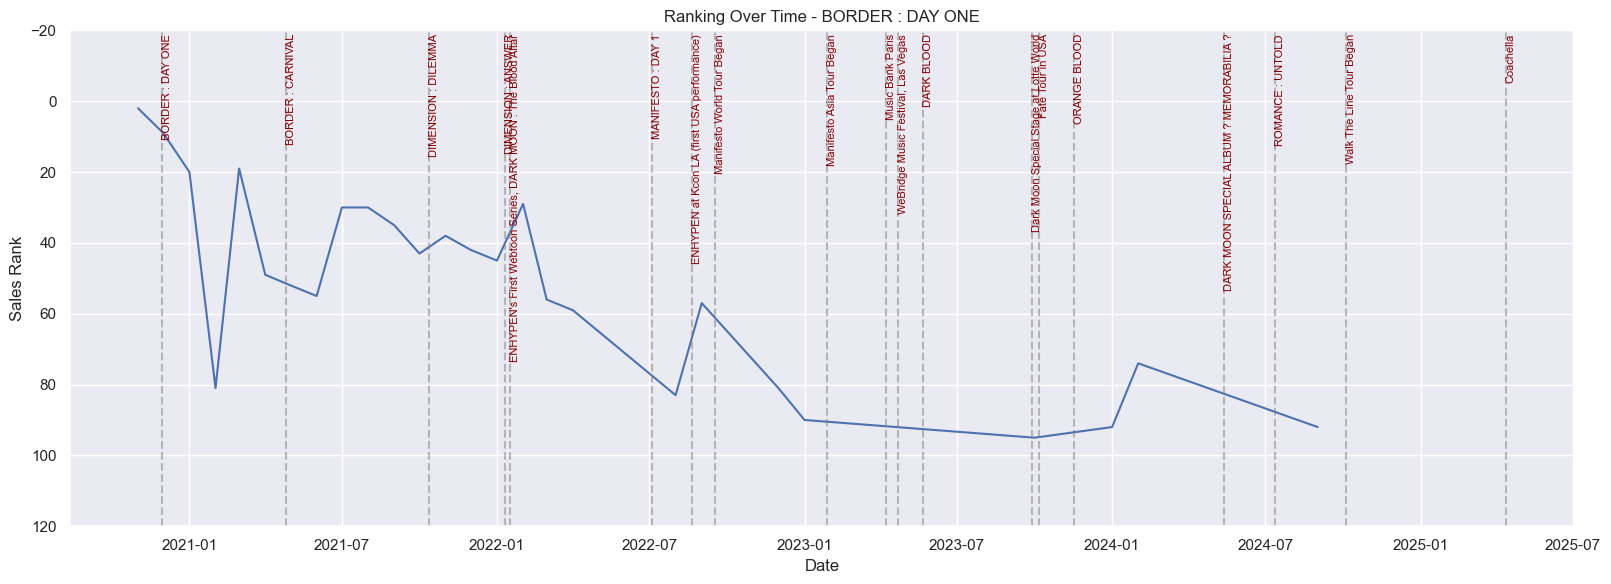

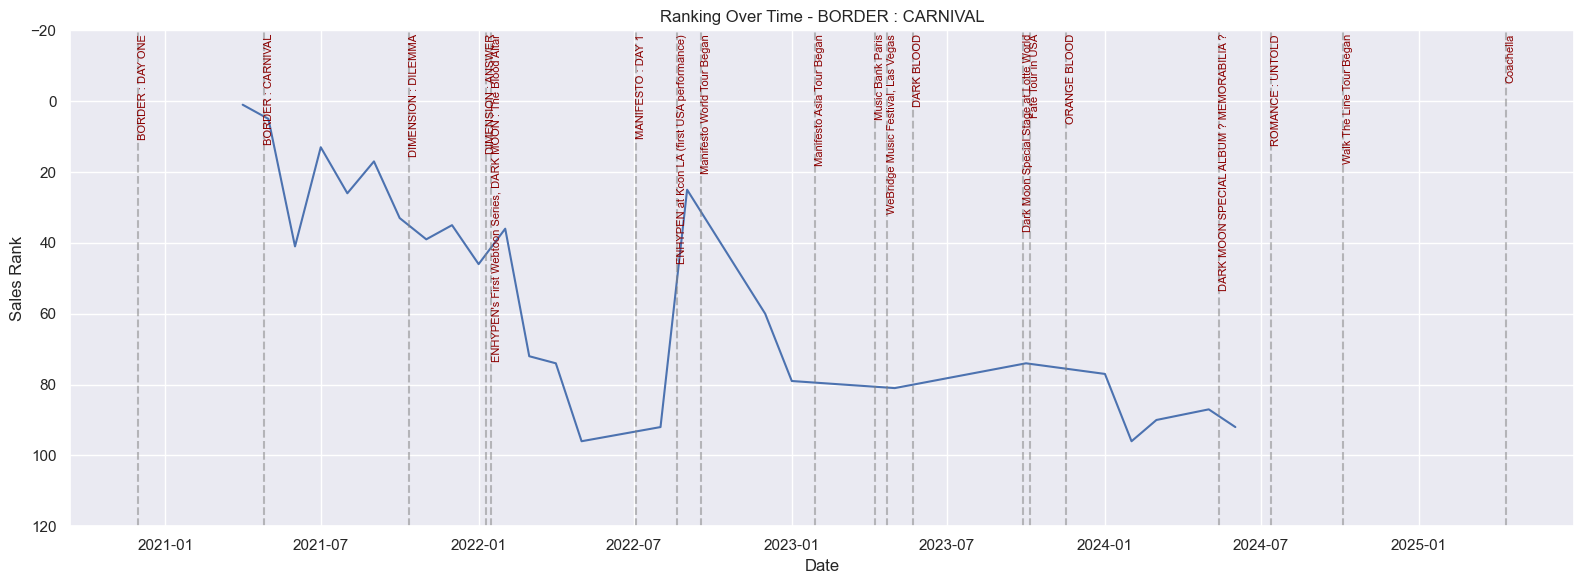

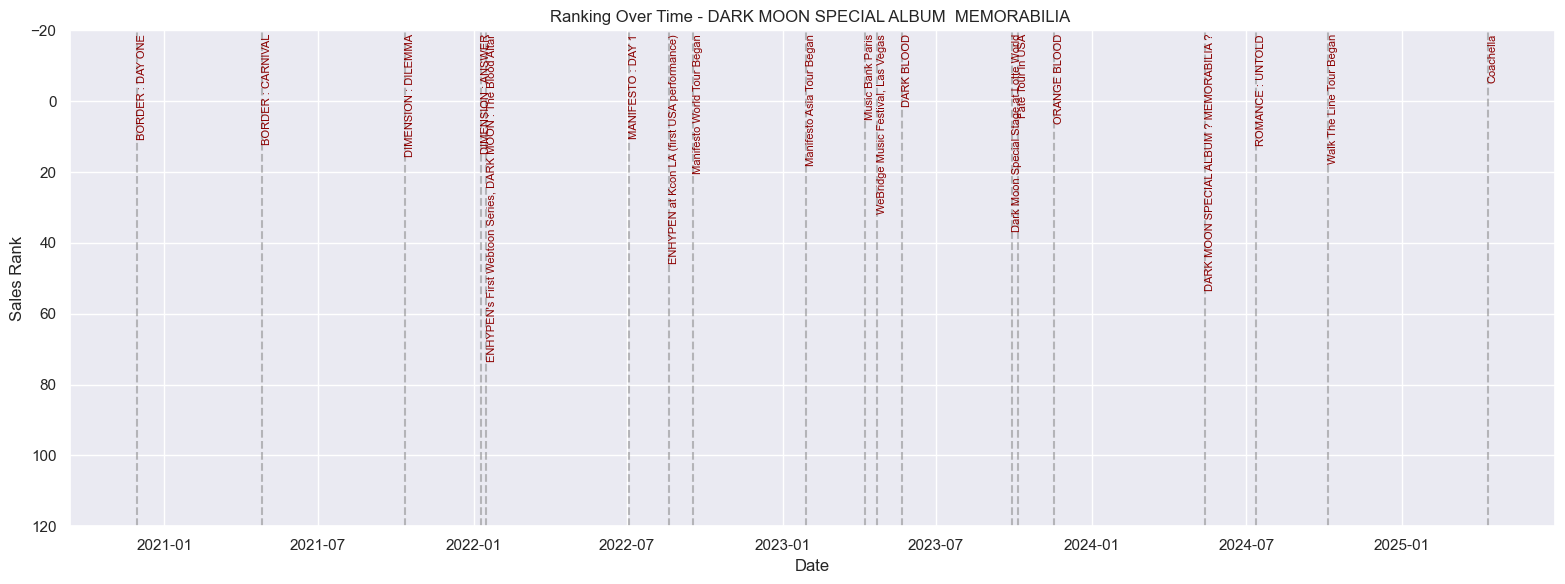

In [88]:
# Group by album
albums = monthly_album_sales_ranking['album'].unique()

for album in albums:
    subset = monthly_album_sales_ranking[monthly_album_sales_ranking['album'] == album]

    plt.figure(figsize=(16, 6))
    ax=sns.lineplot(data=subset, x="date", y="rank")
    ax.set(ylim=(-20, 120))
    plt.gca().invert_yaxis()  # Better ranks = lower numbers
    plt.xlabel('Date')
    plt.ylabel('Sales Rank')
    plt.title(f"Ranking Over Time - {album}")
    plt.grid(True)
    plt.tight_layout()
    for _, row in notable_events.iterrows():
        plt.axvline(row['date'], color='gray', linestyle='--', alpha=0.5)
        plt.text(row['date'], plt.ylim()[1]*0.95, row['event'],
                 rotation=90, verticalalignment='top', fontsize=8, color='darkred')
    plt.savefig(f"{album}_ranking.png", dpi=300, bbox_inches='tight')
    plt.show()

We can see that some of the albums have similar patterns, for example a spike in rankings around Jan-Feb 2024. 

Here's an excerpt of r/enhypen monthly recap that could give an explanation : 

"In January 2024 Enhypen has been on their Fate in Asia tour in Taipei, Singapore and Macau. In-between tour stops they also attended 2 festivals in Japan"

In [89]:
summary_df = pd.DataFrame()

for album in albums:
    subset = monthly_album_sales_ranking[monthly_album_sales_ranking['album'] == album]
    desc = subset['rank'].describe()
    desc.name = album #to set the row name
    summary_df = pd.concat([summary_df, desc], axis=1)

summary_df = summary_df.T  # transpose for readability (albums as rows)
summary_df

,count,mean,std,min,25%,50%,75%,max
ROMANCE : UNTOLD,9.0,34.000000,19.189841,2.0,24.00,42.0,45.00,55.0
DIMENSION : DILEMMA,32.0,63.843750,24.743992,2.0,56.25,65.5,81.50,99.0
ROMANCE : UNTOLD -daydream-,4.0,37.250000,33.390368,2.0,16.25,34.0,55.00,79.0
DARK BLOOD,19.0,60.684211,25.458141,2.0,48.50,70.0,80.00,89.0
ORANGE BLOOD,13.0,37.538462,22.820369,4.0,28.00,34.0,41.00,97.0
DIMENSION : ANSWER,17.0,72.058824,25.532995,1.0,53.00,84.0,87.00,97.0
MANIFESTO : DAY 1,4.0,67.000000,43.458793,2.0,63.50,87.5,91.00,91.0
BORDER : DAY ONE,26.0,52.230769,27.129774,2.0,31.25,50.5,79.25,95.0
BORDER : CARNIVAL,25.0,55.480000,31.130264,1.0,33.00,60.0,81.00,96.0
DARK MOON SPECIAL ALBUM MEMORABILIA,1.0,8.000000,NaN,8.0,8.00,8.0,8.00,8.0


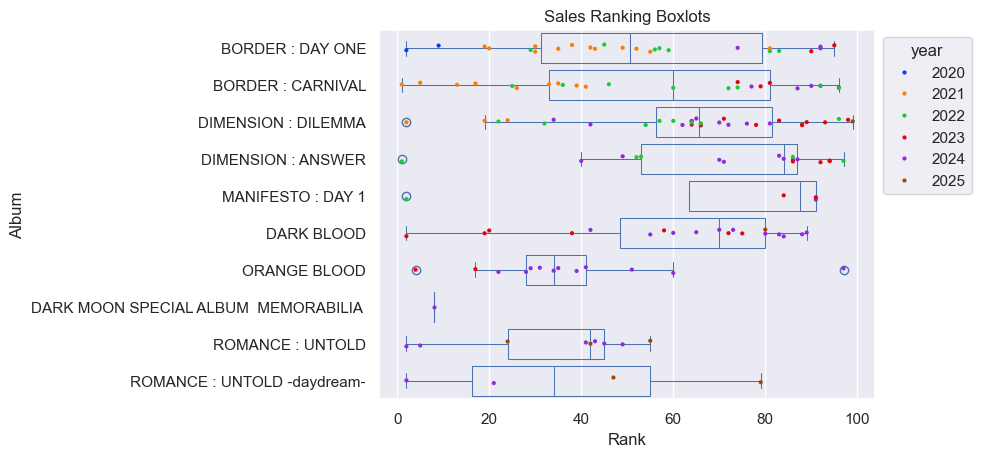

In [90]:
album_order = monthly_album_sales_ranking.groupby('album')['date'].min().sort_values().index
sns.boxplot(data=monthly_album_sales_ranking, x=monthly_album_sales_ranking['rank'], y=monthly_album_sales_ranking['album'], order=album_order, fill=False, linewidth=.75)
ax=sns.stripplot(data=monthly_album_sales_ranking, x=monthly_album_sales_ranking['rank'], y=monthly_album_sales_ranking['album'], 
                 hue=monthly_album_sales_ranking['year'], palette='bright', size=3, jitter=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Rank")
plt.ylabel("Album")
plt.title("Sales Ranking Boxlots")
plt.savefig("enhypen_albums_boxplot.png", dpi=300, bbox_inches='tight')

Amongst the older albums (released in 2020-2021), DIMENSION : DILEMMA seems to perform the best in the long run. It has the most sales in the recent years.

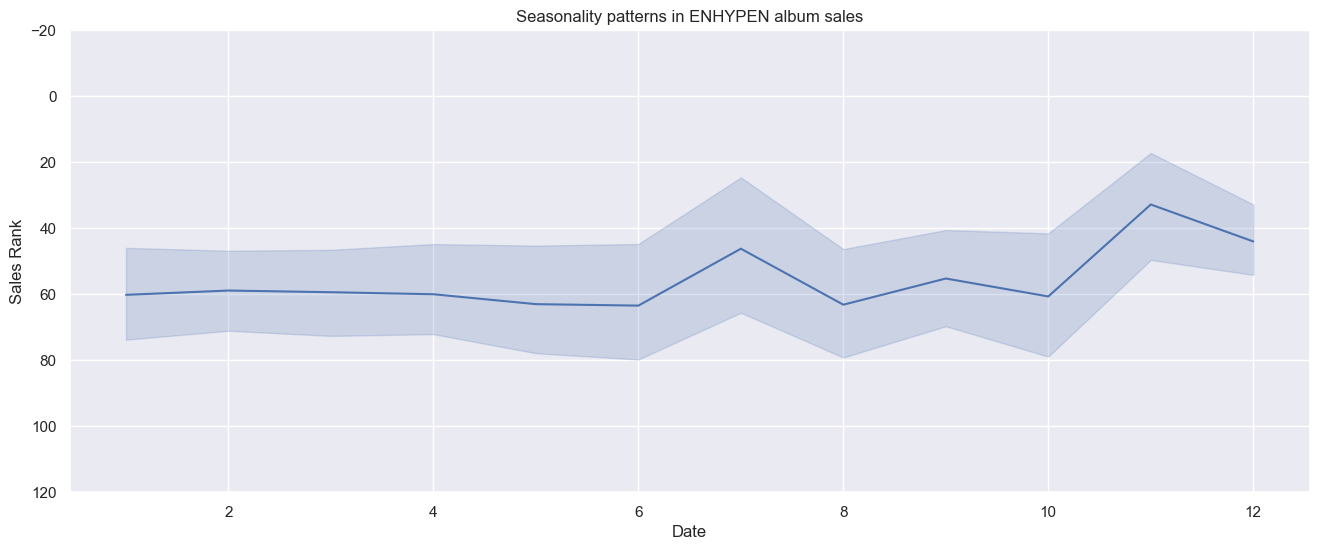

In [91]:
plt.figure(figsize=(16, 6))
ax=sns.lineplot(data=monthly_album_sales_ranking, x="month", y="rank")
ax.set(ylim=(-20, 120))
plt.gca().invert_yaxis()  # Better ranks = lower numbers
plt.xlabel('Date')
plt.ylabel('Sales Rank')
plt.title('Seasonality patterns in ENHYPEN album sales')
plt.grid(True)
plt.savefig("seasonality_patterns.png", dpi=300, bbox_inches='tight')

We can observe increase in sales around July and November. Recent comebacks have been following these trends : ROMANCE UNTOLD came out on July 12, 2024 and ROMANCE : UNTOLD -daydream- was released on November 11, 2024. Generally, ENHYPEN comebacks usually follow a release rhythm : one release in Spring/Summer and another in late Autumn/Winter. 

## Sentiment analysis across kpop subreddits

### VADER

<div class="alert alert-block alert-info">
<b>Data source:</b> Reddit posts (r/kpop, r/kpopthoughts, r/kpop_uncensored, r/kpoppers, r/unpopularkpopopinions, r/enhypen, r/Enhypenthoughts).

_You can see how I collected the data in the get_reddit_data.py script._ 
</div>

In [92]:
reddit_posts = pd.read_csv('data/enha_reddit_posts.csv', sep=",", encoding='utf-8')
reddit_posts = reddit_posts.dropna(subset=['selftext'])

The next cell is commented because you only have to run it once to download the NLTK library.

In [93]:
# nltk.download('all')

In [94]:
def remove_URL(text):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(string):
    return re.sub(r'[^\w\s]', '', string)

reddit_posts['processed_text'] = reddit_posts['selftext'].apply(remove_URL)
reddit_posts['processed_text'] = reddit_posts['processed_text'].apply(remove_emoji)
reddit_posts['processed_text'] = reddit_posts['processed_text'].apply(remove_punctuation)
reddit_posts

,sub,id,created_date,title,selftext,score,num_comments,processed_text
23,kpop,1lgundi,2025-06-21 13:45:33,"This Week In KPOP - June 21, 2025",Welcome to [This Week In KPOP](https://i.imgur...,4,1,Welcome to This Week In KPOP a collection of e...
40,kpop,1l3px4g,2025-06-05 06:07:33,ENHYPEN - DESIRE : UNLEASH (6th Mini Album),#[ENHYPEN - DESIRE : UNLEASH](https://preview....,206,70,ENHYPEN DESIRE UNLEASH\n\nRelease Date 5 Jun...
47,kpop,1lbfqb2,2025-06-14 20:37:03,"This Week In KPOP - June 14, 2025",Welcome to [This Week In KPOP](https://i.imgur...,32,7,Welcome to This Week In KPOP a collection of e...
63,kpop,1l5l6zu,2025-06-07 15:45:13,"This Week In KPOP - June 7, 2025",Welcome to [This Week In KPOP](https://i.imgur...,23,1,Welcome to This Week In KPOP a collection of e...
112,kpop,1kaxjqi,2025-04-29 22:07:08,"The ""2024 in B-sides"" Rate!",[Hello everyone!](https://i.imgur.com/4Hb7mUH....,35,2,Hello everyone Weve explored the singles of KP...
...,...,...,...,...,...,...,...,...
3045,Enhypenthoughts,1hk80lp,2024-12-22 22:19:54,romance untold daydream album pulls!!,IM SO HAPPY WITH EVERYTHING I GOT LIKE AHHHHHH...,92,15,IM SO HAPPY WITH EVERYTHING I GOT LIKE AHHHHHH...
3046,Enhypenthoughts,1hjwcke,2024-12-22 11:58:21,Support??💗,Guys i recently opened a bandlab and i cover s...,32,0,Guys i recently opened a bandlab and i cover s...
3047,Enhypenthoughts,1hjw9jx,2024-12-22 11:51:40,Fave kpop comeback this year?,This year definitely had its up and downs(more...,19,31,This year definitely had its up and downsmore ...
3048,Enhypenthoughts,1hjkpy8,2024-12-21 23:22:47,Enhypens Sunoo,Guys i really don’t know what to say except i ...,175,22,Guys i really dont know what to say except i l...


In [95]:
# create preprocess_text function
def preprocess_text(text):
# 
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# apply the function df
reddit_posts['processed_text'] = reddit_posts['processed_text'].apply(preprocess_text)
reddit_posts

,sub,id,created_date,title,selftext,score,num_comments,processed_text
23,kpop,1lgundi,2025-06-21 13:45:33,"This Week In KPOP - June 21, 2025",Welcome to [This Week In KPOP](https://i.imgur...,4,1,welcome week kpop collection everything may mi...
40,kpop,1l3px4g,2025-06-05 06:07:33,ENHYPEN - DESIRE : UNLEASH (6th Mini Album),#[ENHYPEN - DESIRE : UNLEASH](https://preview....,206,70,enhypen desire unleash release date 5 june 202...
47,kpop,1lbfqb2,2025-06-14 20:37:03,"This Week In KPOP - June 14, 2025",Welcome to [This Week In KPOP](https://i.imgur...,32,7,welcome week kpop collection everything may mi...
63,kpop,1l5l6zu,2025-06-07 15:45:13,"This Week In KPOP - June 7, 2025",Welcome to [This Week In KPOP](https://i.imgur...,23,1,welcome week kpop collection everything may mi...
112,kpop,1kaxjqi,2025-04-29 22:07:08,"The ""2024 in B-sides"" Rate!",[Hello everyone!](https://i.imgur.com/4Hb7mUH....,35,2,hello everyone weve explored single kpop 2024 ...
...,...,...,...,...,...,...,...,...
3045,Enhypenthoughts,1hk80lp,2024-12-22 22:19:54,romance untold daydream album pulls!!,IM SO HAPPY WITH EVERYTHING I GOT LIKE AHHHHHH...,92,15,im happy everything got like ahhhhhhhhhhhh hop...
3046,Enhypenthoughts,1hjwcke,2024-12-22 11:58:21,Support??💗,Guys i recently opened a bandlab and i cover s...,32,0,guy recently opened bandlab cover song group s...
3047,Enhypenthoughts,1hjw9jx,2024-12-22 11:51:40,Fave kpop comeback this year?,This year definitely had its up and downs(more...,19,31,year definitely downsmore down ups tbh get goo...
3048,Enhypenthoughts,1hjkpy8,2024-12-21 23:22:47,Enhypens Sunoo,Guys i really don’t know what to say except i ...,175,22,guy really dont know say except love sunoo bia...


In [96]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

res = {}
for _, row in reddit_posts.iterrows(): 
    text = row['processed_text']
    myID = row['id']
    res[myID] = analyzer.polarity_scores(text)

results_df = pd.DataFrame(res)
results_df = results_df.T
results_df.index.name = 'id'

final_results = reddit_posts.merge(results_df, on='id', how='inner')

def classify_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

final_results['sentiment'] = final_results['processed_text'].apply(classify_sentiment)

In [97]:
reduced_df = final_results[["sub", "selftext", "sentiment"]]
negative_sentiments = reduced_df[final_results['sentiment'] ==  'negative']

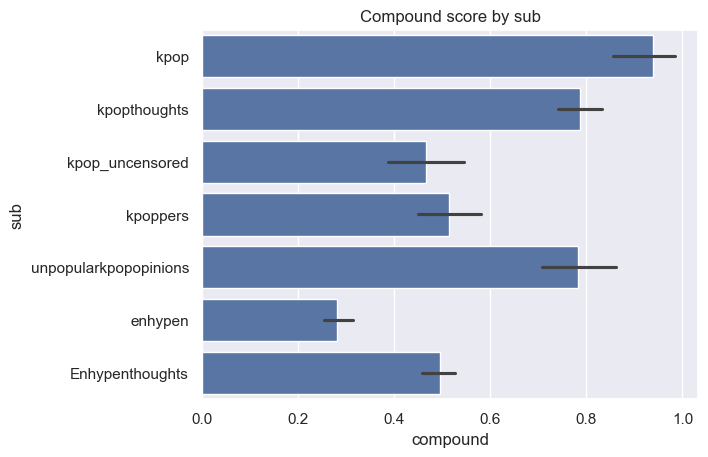

In [98]:
ax = sns.barplot(data=final_results, x="compound", y="sub")
ax.set_title("Compound score by sub")
plt.savefig("VADER_compound_scores.png", dpi=300, bbox_inches='tight')
plt.show()

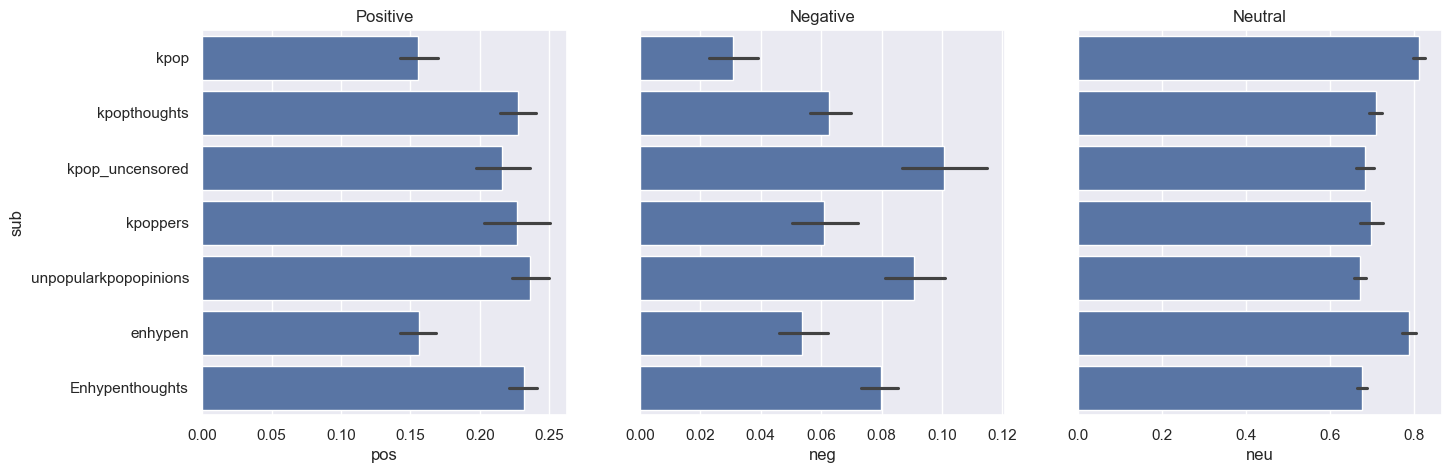

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey=True)
sns.barplot(data=final_results, x="pos", y="sub", ax=axs[0])
sns.barplot(data=final_results, x="neg", y="sub", ax=axs[1])
sns.barplot(data=final_results, x="neu", y="sub", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Negative")
axs[2].set_title("Neutral")
plt.savefig("VADER_pos_neg_neu_scores.png", dpi=300, bbox_inches='tight')
plt.show()

### RoBERTA

In [100]:
roberta_results = pd.read_csv('roberta_results.csv', sep="\t", encoding='utf-8')
roberta_results['created_date'] = pd.to_datetime(roberta_results['created_date'])

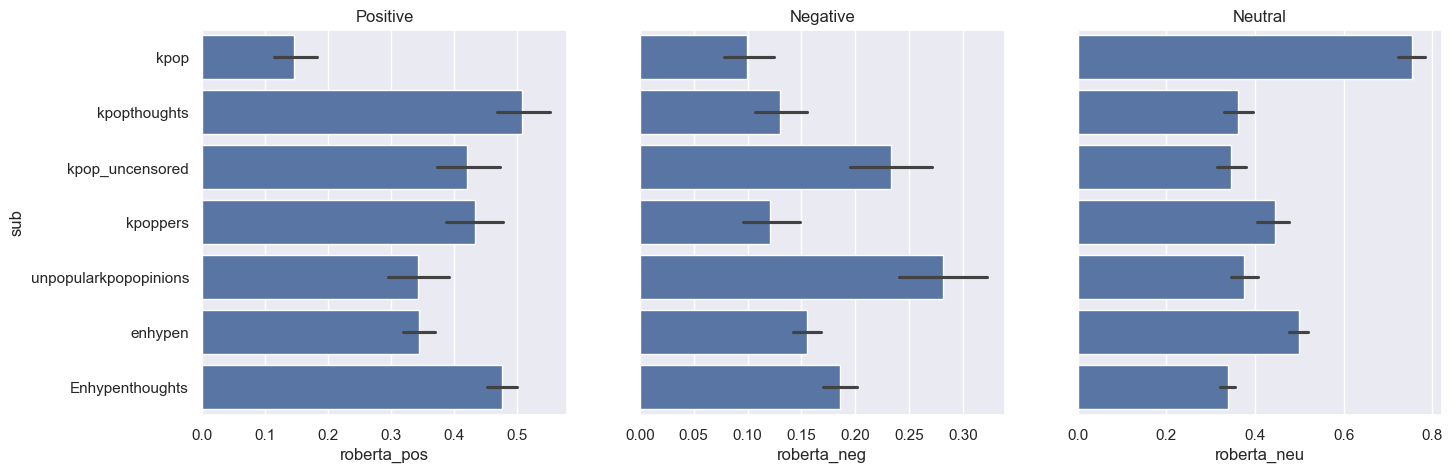

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey=True)
sns.barplot(data=roberta_results, x="roberta_pos", y="sub", ax=axs[0])
sns.barplot(data=roberta_results, x="roberta_neg", y="sub", ax=axs[1])
sns.barplot(data=roberta_results, x="roberta_neu", y="sub", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Negative")
axs[2].set_title("Neutral")
plt.savefig("RoBERTa_pos_neg_neu_scores.png", dpi=300, bbox_inches='tight')
plt.show()

In [102]:
subs = roberta_results['sub'].unique()

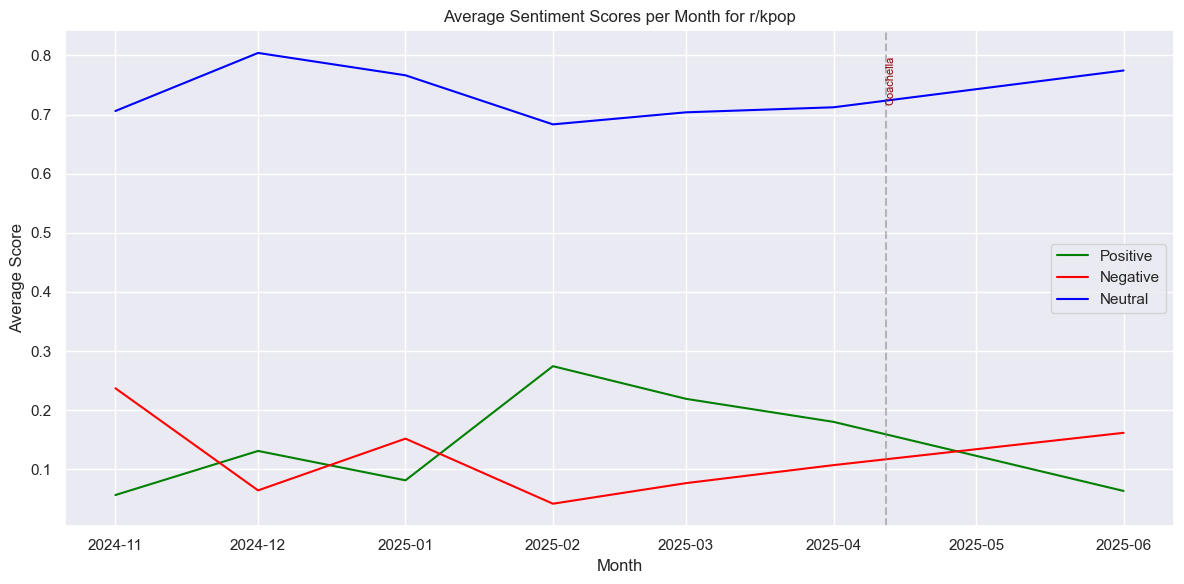

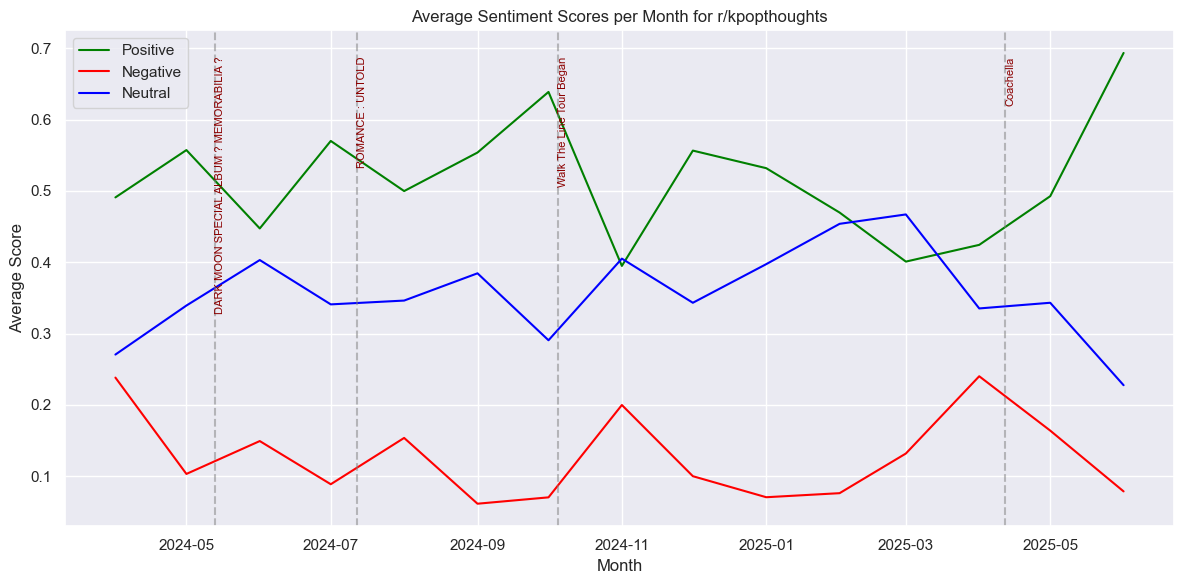

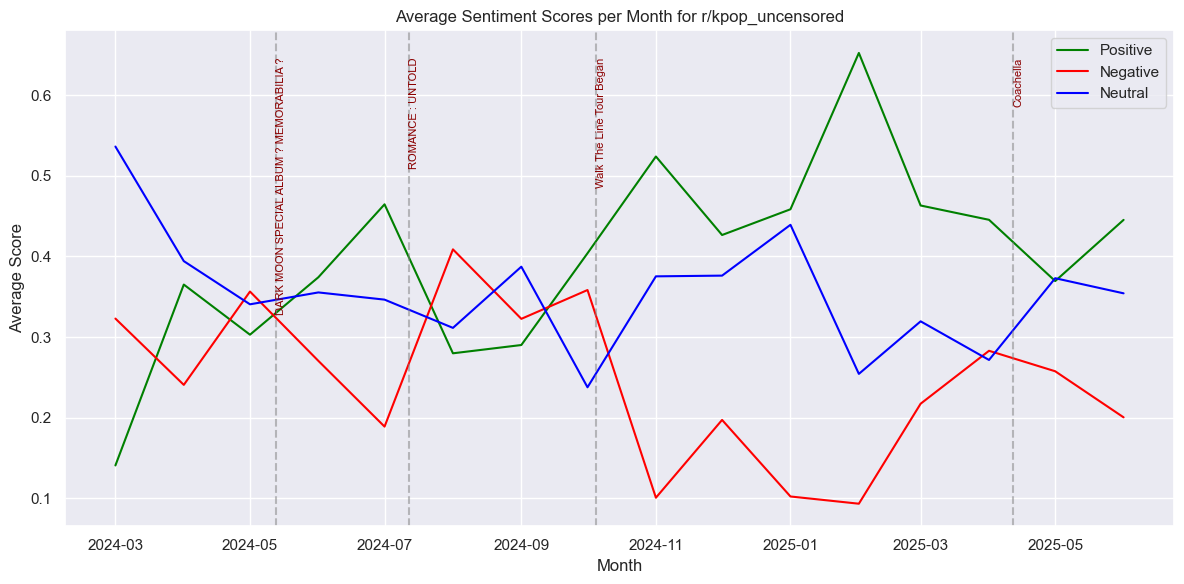

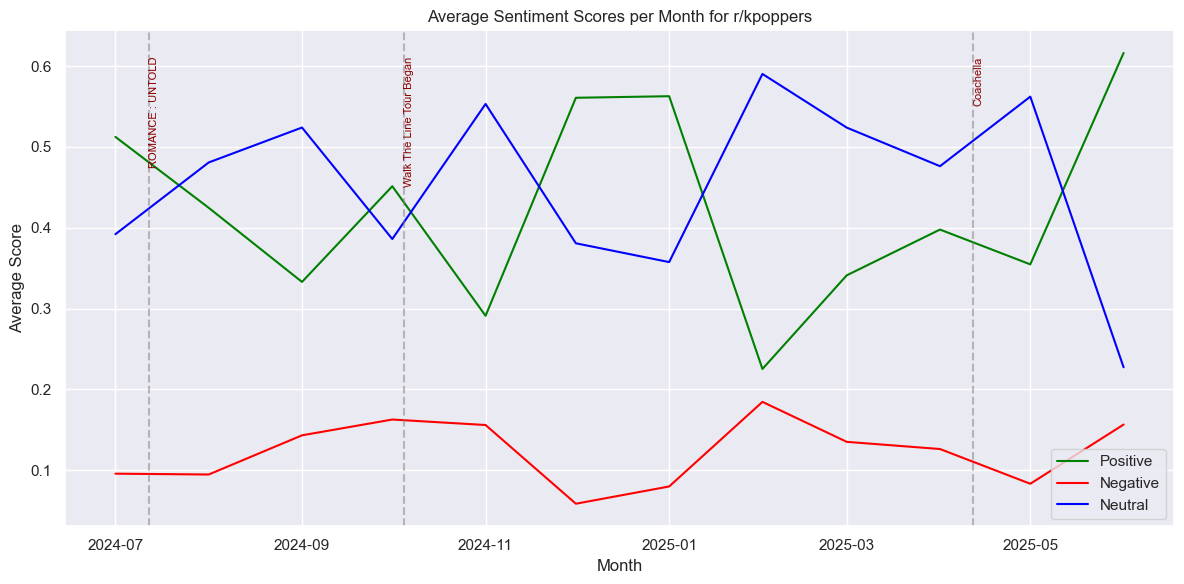

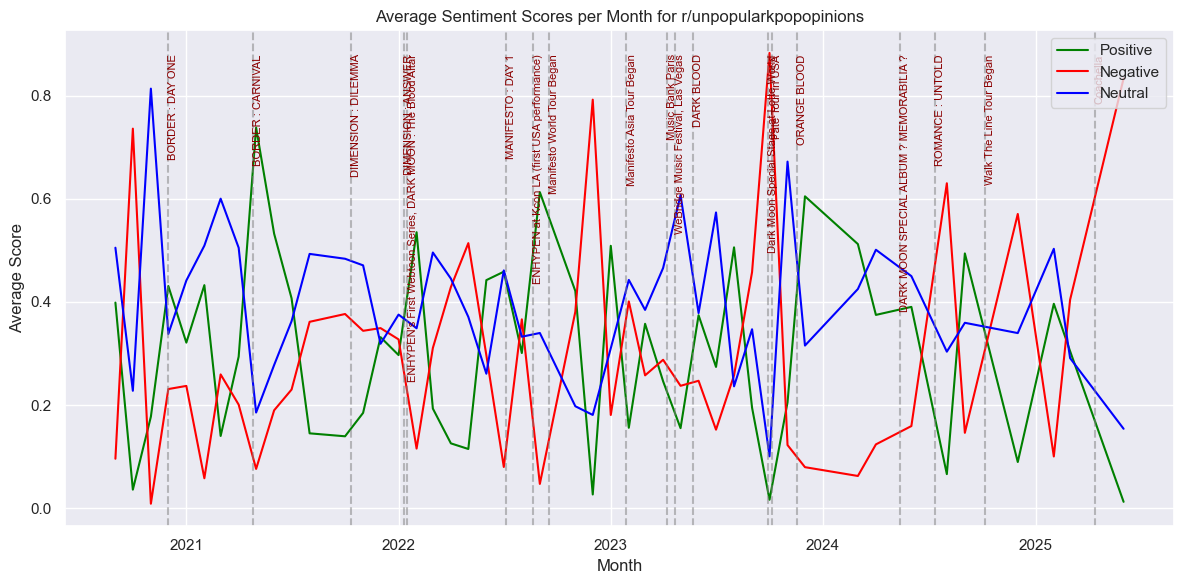

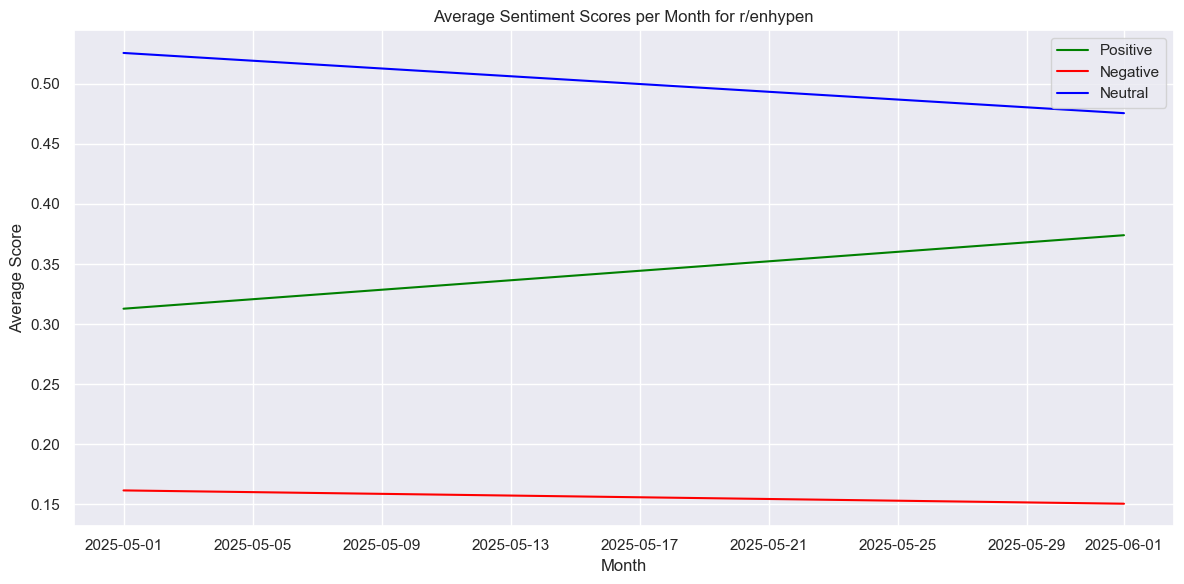

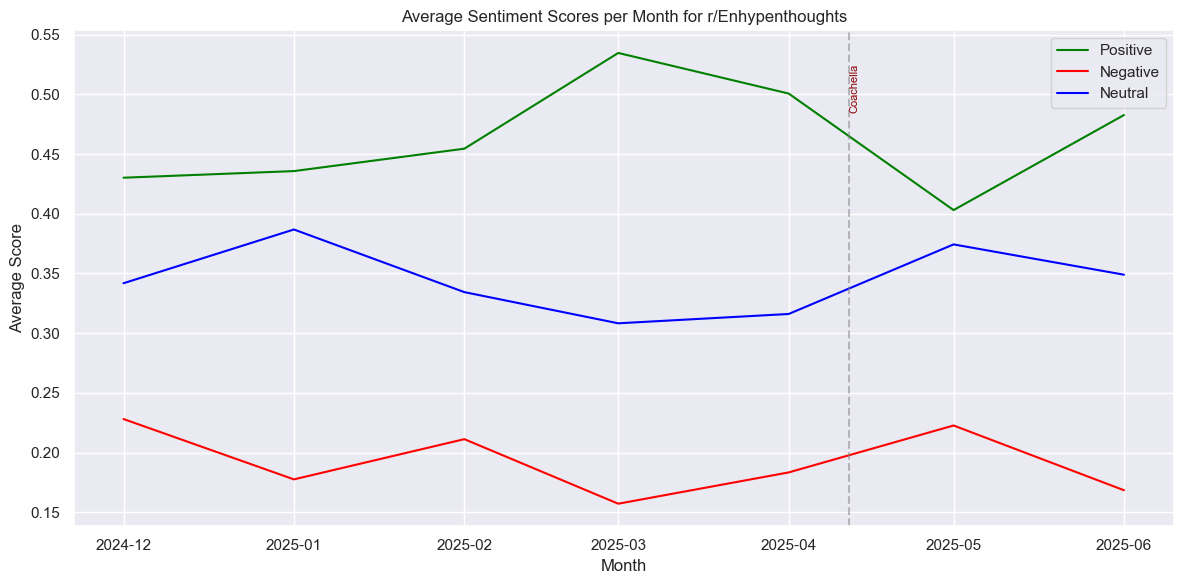

In [103]:
roberta_results['month'] = roberta_results['created_date'].dt.to_period('M').dt.to_timestamp()

for x in subs:
    subset = roberta_results[roberta_results['sub'] == x]
    monthly_avg_results = subset.groupby('month')[['roberta_pos', 'roberta_neg', 'roberta_neu']].mean()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg_results.index, monthly_avg_results['roberta_pos'], label='Positive', color='green')
    plt.plot(monthly_avg_results.index, monthly_avg_results['roberta_neg'], label='Negative', color='red')
    plt.plot(monthly_avg_results.index, monthly_avg_results['roberta_neu'], label='Neutral', color='blue')
    # plt.title('Average Sentiment Scores per Month')
    plt.title(f'Average Sentiment Scores per Month for r/{x}')
    plt.xlabel('Month')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    start_date = min(monthly_avg_results.index)
    end_date = max(monthly_avg_results.index)
    
    cropped_events = notable_events[
        (notable_events['date'] >= start_date) &
        (notable_events['date'] <= end_date)
    ]
    
    for _, row in cropped_events.iterrows():
        plt.axvline(row['date'], color='gray', linestyle='--', alpha=0.5)
        plt.text(row['date'], plt.ylim()[1]*0.95, row['event'],
                 rotation=90, verticalalignment='top', fontsize=8, color='darkred')
    plt.savefig(f"{x}_RoBERTa_sentiment.png", dpi=300, bbox_inches='tight')
    plt.show()

In [104]:
roberta_results["sub"].unique()

array(['kpop', 'kpopthoughts', 'kpop_uncensored', 'kpoppers',
       'unpopularkpopopinions', 'enhypen', 'Enhypenthoughts'],
      dtype=object)

In [106]:
roberta_negatives = roberta_results["roberta_neg"]
r_kpop = roberta_negatives[(roberta_results['sub'] == "kpop")]
r_kpopthoughts = roberta_negatives[(roberta_results['sub'] == "kpopthoughts")]
r_kpop_uncensored = roberta_negatives[(roberta_results['sub'] == "kpop_uncensored")]
r_kpoppers = roberta_negatives[(roberta_results['sub'] == "kpoppers")]
r_unpopularkpopopinions = roberta_negatives[(roberta_results['sub'] == "unpopularkpopopinions")]
r_enhypen = roberta_negatives[(roberta_results['sub'] == "enhypen")]
r_Enhypenthoughts = roberta_negatives[(roberta_results['sub'] == "Enhypenthoughts")]

In [107]:
f_statistic, p_value = f_oneway(r_kpop, r_kpopthoughts, r_kpop_uncensored, r_kpoppers, r_unpopularkpopopinions, r_enhypen, r_Enhypenthoughts)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 12.658875613700092
P-value: 4.0920738494916536e-14


There is no significant difference between the different subreddits.

### Event-centric analysis (only with RoBERTa results)

In [108]:
# Define the window size for sentiment comparison (you can vary it accordingly. 30 day window just guarantees enough data
window_size = 30

In [109]:
# We'll use a t-test

event_analysis = []

for _, row in notable_events.iterrows():
    event_date = row['date']
    event_name = row['event']
    
    # Define time windows
    before_start = event_date - timedelta(days=window_size)
    before_end = event_date
    after_start = event_date
    after_end = event_date + timedelta(days=window_size)
    
    # Subset sentiment data
    pre_event = roberta_results[
        (roberta_results['created_date'] >= before_start) &
        (roberta_results['created_date'] < before_end)
    ]
    
    post_event = roberta_results[
        (roberta_results['created_date'] > after_start) &
        (roberta_results['created_date'] <= after_end)
    ]
    
    # Compute means for negative sentiment
    pre_mean_neg = pre_event['roberta_neg'].mean()
    post_mean_neg = post_event['roberta_neg'].mean()

    # Compute means for positive sentiment
    pre_mean_pos = pre_event['roberta_pos'].mean()
    post_mean_pos = post_event['roberta_pos'].mean()
    
    # Statistical test for negative sentiment
    t_stat_neg, p_val_neg = ttest_ind(pre_event['roberta_neg'], post_event['roberta_neg'], equal_var=False, nan_policy='omit')

    # Statistical test for negative sentiment
    t_stat_pos, p_val_pos = ttest_ind(pre_event['roberta_pos'], post_event['roberta_pos'], equal_var=False, nan_policy='omit')
    
    event_analysis.append({
        'event': event_name,
        'date': event_date,
        'pre_mean_neg': pre_mean_neg,
        'post_mean_neg': post_mean_neg,
        'pre_mean_pos': pre_mean_pos,
        'post_mean_pos': post_mean_pos,
        'diff_neg': post_mean_neg - pre_mean_neg,
        'diff_pos': post_mean_pos - pre_mean_pos,
        'p_value_neg': p_val_neg,
        'p_value_pos': p_val_pos
    })

C:\Users\Pauline Leumani\.conda\envs\enhypen\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [110]:
event_df = pd.DataFrame(event_analysis)
event_df

,event,date,pre_mean_neg,post_mean_neg,pre_mean_pos,post_mean_pos,diff_neg,diff_pos,p_value_neg,p_value_pos
0,BORDER : DAY ONE,2020-11-30,NaN,0.203373,NaN,0.399229,NaN,NaN,NaN,NaN
1,BORDER : CARNIVAL,2021-04-26,0.039850,0.124099,0.634230,0.594633,0.084248,-0.039597,NaN,NaN
2,DIMENSION : DILEMMA,2021-10-12,NaN,0.359395,NaN,0.159801,NaN,NaN,NaN,NaN
3,DIMENSION : ANSWER,2022-01-10,0.292291,0.244513,0.344383,0.398220,-0.047778,0.053836,0.782344,0.782619
4,"ENHYPEN's First Webtoon Series, DARK MOON : Th...",2022-01-16,0.224110,0.289447,0.422457,0.390518,0.065338,-0.031938,0.678136,0.866575
5,MANIFESTO : DAY 1,2022-07-04,0.296787,0.080192,0.442316,0.458644,-0.216595,0.016328,0.566508,0.973770
6,ENHYPEN at Kcon LA (first USA performance),2022-08-20,0.372760,0.065343,0.311285,0.511282,-0.307417,0.199997,0.195327,0.318794
7,Manifesto World Tour Began,2022-09-17,0.065343,NaN,0.511282,NaN,NaN,NaN,NaN,NaN
8,Manifesto Asia Tour Began,2023-01-28,0.180929,0.401121,0.508857,0.156134,0.220192,-0.352724,0.523108,0.416589
9,Music Bank Paris,2023-04-08,0.424075,0.287922,0.139265,0.246268,-0.136153,0.107003,NaN,NaN


C:\Users\Pauline Leumani\AppData\Local\Temp\ipykernel_3616\3587474122.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


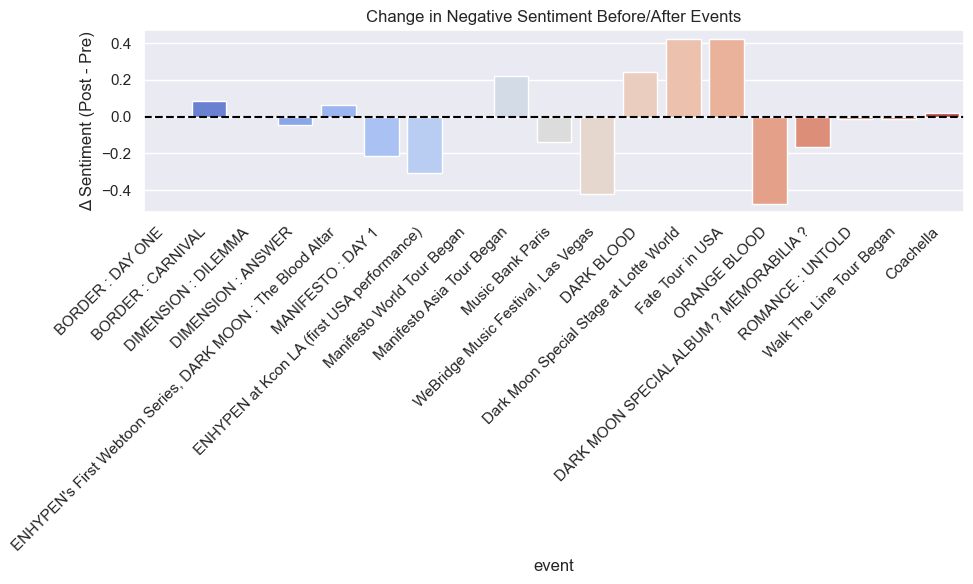

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=event_df,
    x='event',
    y='diff_neg',
    palette='coolwarm',
)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Δ Sentiment (Post - Pre)")
plt.xticks(rotation=45, ha='right')
plt.title("Change in Negative Sentiment Before/After Events")
plt.tight_layout()
plt.savefig("RoBERTa_negative_sentiment_change.png", dpi=300, bbox_inches='tight')
plt.show()

Negative delta = decrease in negative sentiment; positive delta = increase in negative sentiment. 
Live events like KCON and WeBridge music festival contributed to decrease the negativity online. Only 2 album releases had the same effect : MANIFESTO : DAY 1 and ORANGE BLOOD (which have brigther concepts).
Surprisingly, vampire heavy concepts were met less positively.

C:\Users\Pauline Leumani\AppData\Local\Temp\ipykernel_3616\3904469584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


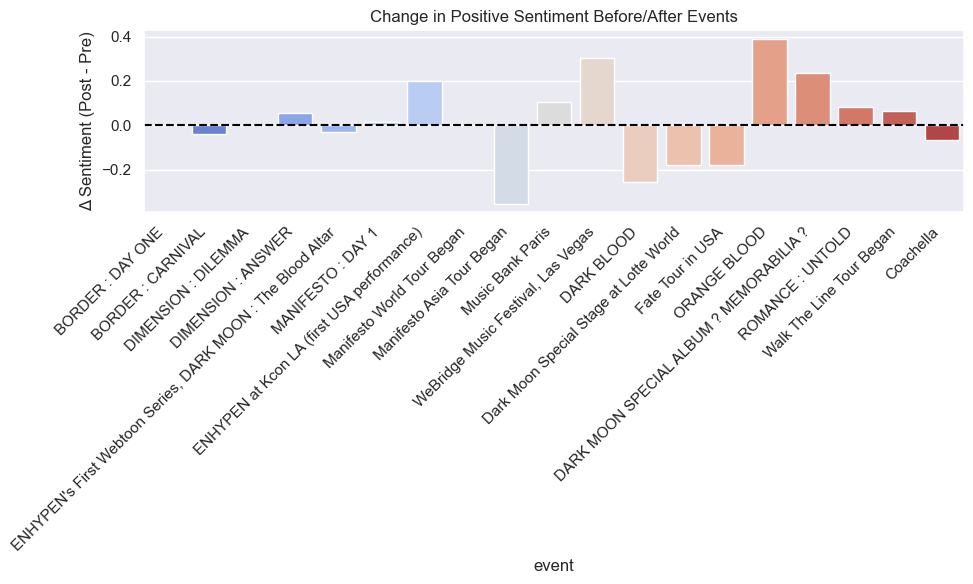

In [112]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=event_df,
    x='event',
    y='diff_pos',
    palette='coolwarm',
)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Δ Sentiment (Post - Pre)")
plt.xticks(rotation=45, ha='right')
plt.title("Change in Positive Sentiment Before/After Events")
plt.tight_layout()
plt.savefig("RoBERTa_positive_sentiment_change.png", dpi=300, bbox_inches='tight')
plt.show()

This graph confirms some of the previous observations : amongst the most positively met albums we can find ORANGE BLOOD. MEMORABILIA also contributed to increase the positive sentiment. We can also see the increase in positivity after the music events (except tours and Coachella, whih had an opposite effect). 
These conlusions are obviously not reliable, since correlation does not equate causality. There could be some controversies overlapping with certain events (example : Manifesto Asia Tour Began in January 2023. On January 10th, ENHYPEN Jay and Sunghoon did a Weverse live which caused a controversy on Jay's remarks on Korean History.
Overall, there is increase in positive sentiment since ORANGE BLOOD release.

We also have to keep in mind that this analysis concerns only top Reddit posts. Plus, sometimes the sentiment of a text can be negative but the user expresses an idea favorable to ENHYPEN (for example, the sentiment of the phase "I hate that EHYPEN gets so little recognition in South Korea" will be classified as negative, although it conveys a supportive message).

## Spotify data

<div class="alert alert-block alert-info">
<b>Data source:</b> Spotify track popularity scores.

_You can see how I collected the data in the get_spotify_data.py script._ 
</div>

In [113]:
spotify_popularity = pd.read_csv('data/spotify_popularity_scores.csv', sep=",", encoding='utf-8')

In [114]:
# Since the Spotify API gets us albums and singles (including EPs) we have to filter on the items we need
spotify_popularity = spotify_popularity[spotify_popularity['album'].isin(['ROMANCE : UNTOLD -daydream-',
                                                                          'ROMANCE : UNTOLD',
                                                                          'DESIRE : UNLEASH',
                                                                          'DIMENSION : ANSWER',
                                                                          'DIMENSION : DILEMMA',
                                                                          'ORANGE BLOOD',
                                                                          'DARK BLOOD',
                                                                          'DARK MOON SPECIAL ALBUM <MEMORABILIA>',
                                                                          'BORDER : CARNIVAL',
                                                                          'MANIFESTO : DAY 1',
                                                                          'BORDER : DAY ONE'
                                                                         ])]
spotify_popularity

,album,track,popularity
0,DESIRE : UNLEASH,Flashover,69
1,DESIRE : UNLEASH,Bad Desire (With or Without You),81
2,DESIRE : UNLEASH,Outside,76
3,DESIRE : UNLEASH,Loose (Korean Ver.),66
4,DESIRE : UNLEASH,Helium,74
...,...,...,...
129,BORDER : DAY ONE,Given-Taken,72
130,BORDER : DAY ONE,Let Me In (20 CUBE),63
131,BORDER : DAY ONE,10 Months,62
132,BORDER : DAY ONE,Flicker,60


In [115]:
album_popularity = spotify_popularity.groupby('album')['popularity'].agg(['mean', 'sum'])
album_popularity.sort_values(by='mean', ascending=False)

,mean,sum
album,,
DESIRE : UNLEASH,73.000000,584
ROMANCE : UNTOLD,67.222222,605
DARK BLOOD,66.666667,400
DARK MOON SPECIAL ALBUM <MEMORABILIA>,63.333333,380
BORDER : CARNIVAL,61.833333,371
ORANGE BLOOD,61.714286,432
MANIFESTO : DAY 1,61.500000,369
ROMANCE : UNTOLD -daydream-,60.000000,660
BORDER : DAY ONE,59.000000,354


I ordered by the average popularity, as I concider it to be more representative than just a sum. The most popular album as of today is DESIRE : UNLEASH (unfourtunately, at the beginning of this project, it wasn't out yet so I have no other data on it) which is logical since it is the latest one. Unlike what previous analysis has showed us, the lore-heavy albums are very popular amongst the listeners. Where the sales analysis has showed us that amongst the oldest albums DIMENSION : DILEMMA was the most lasting one, in terms on song popularity BORDER : CARNIVAL wins. 
Generally, the most coherent albums (where the visual concept and audio are weeved organically together) gain popularity.

Let's compare album sales ranks and Spotify popularity scores.

In [116]:
album_ranking_mean = monthly_album_sales_ranking.groupby('album')['rank'].agg(['mean'])
album_ranking_mean.sort_values(by='mean', ascending=True)

,mean
album,
DARK MOON SPECIAL ALBUM MEMORABILIA,8.000000
ROMANCE : UNTOLD,34.000000
ROMANCE : UNTOLD -daydream-,37.250000
ORANGE BLOOD,37.538462
BORDER : DAY ONE,52.230769
BORDER : CARNIVAL,55.480000
DARK BLOOD,60.684211
DIMENSION : DILEMMA,63.843750
MANIFESTO : DAY 1,67.000000


Both in physical sales and Spotify, the ROMANCE : UNTOLD album is the most popular one. However, it is hard to make a statement for MEMORABILIA since the sample size is extremely small. 